

# Predicción de Series Temporales utilizando FbProphet

La predicción de series temporales es de los casos más habituales y aplicables dentro del Machine Learning. Por ejemplo, models de 'forecasting' se pueden encontrar en para la predicción de precios, demanda, temperatura,  tiempo de respuesta, ventas, ritmo cardiaco, producción, etc. 

El gran reto se encuentra en que, a diferencia de algunos otros casos de Machine Learning, la predicción a futuro depende en gran medida, de los datos históricos de la serie. Es decir, por ejemplo si queremos predecir la temperatura media por hora, el dato más relevante que podemos utilizar es la misma serie de temperaturas por hora. A este tipo de modelos se los llama **Auto-regresivos.** 

En la práctica, los modelos auto-regresivos pueden desarrollarse sin ninguna otra variable auxiliar (covariantes), sin embargo, es común añadir regresores externos para complementar el poder predictivo del modelo. 

## Caso de uso: Predicción de la demanda de Bicicletas en una plataforma de BikeSharing en Washington DC. 

Somos Data Scientist en una empresa de Bike Sharing. Básicamente es una aplicación en donde los usuarios pueden registrarse, utilizar bicicletas de nuestra empresa que están localizadas a lo largo de la ciudad, y luego, cuándo llegan a destino, las dejan para que otros usuarios puedan usarlas también. La empresa está en proceso de expansión, por lo que han decidido comprar nuevas bicicletas para colocarlas a lo largo de toda la ciudad. Sin embargo, se ha decidido que se comprarán las bicicletas en función de la cantidad de demanada diaria en el futuro. Por lo que se nos ha pedido que realicemos un modelo de predicción de la demanda. La compra tendrá que hacerse urgentemente, por lo que el reto será predecir la demanda de las siguientes dos semanas. 

- Para ello tenemos datos históricos de demanda y la siguiente información:
    - instant: identificador de la fila.
    - dteday: fecha.
    - hr: hora.
    - weathersit: descripción de la situación climática
    - temp: temperatura en celcius (normalizado con división por 41 (max))
    - atemp: sensación térmica (normalizado, dividido por 50 (max))
    - hum: humedad normalizada. Valores divividos por 100 (max)
    - windspeed: velocidad del viento normalizada
    - casual: conteo de usuarios casuales (no registrados)
    - registered: conteo de usuarios registrados en la app
    - cnt: conteo total usuarios (registrados y casuales). Esta sería la variable objetivo.


Reto: Predecir la demanda de uso para las siguientes dos semanas (14 días)!  



# Importamos paquetes y definimos helpers

Se ha incluído el código base para cargar los datos y transformarlos en formato diario. Además de algunas funciones que nos ayuden a verificar outliers, como también para evaluar el modelo. 

PISTA: Si queremos predecir la cantidad de usuarios, las columnas casual y registered no nos serán útiles ya que contienen información a posteriori. 

In [2]:
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error , r2_score 
import seaborn as sns



def get_median_filtered(signal, threshold=3):
    
    """
    Función que nos permite sacar outliers utilizando el método de la mediana
    filtrada. Es bastante robusto a ruido, por lo que es ideal para series 
    temporales. 
     
    Directamente reemplaza outliers con la mediana!
    Info sobre el método en 
    https://en.wikipedia.org/wiki/Median_filter 
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana    
    :return:   array igual a serie con los outliers reemplazados. 
    
    """
    
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

def plot_outliers_signal(signal, threshold = 3, return_mask = True):
    
    """
    Funcion que plotea los resultados de la funcion
    get_median_filtered
    
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana   
    :param return_mask: Si es True, devuelve los índices donde hubo reemplazo 
    :return:  in plot
    
    """
    
    
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.35)

    mds = get_median_filtered(signal, threshold=threshold)
    outlier_idx = np.where(mds != signal)[0]
    plt.figure(figsize=(10,8))

    plt.plot(signal, color = "darkblue")
    plt.plot(outlier_idx,signal[outlier_idx],**kw, 
            label = "Outliers")
    plt.title("Detección de Outliers con cutoff {}".format(threshold))
    plt.legend()
    plt.show()
    if return_mask: 
      return outlier_idx


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def evaluate(true, pred):
    print('Mean squared error: %.2f'% mean_squared_error(true, pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'% r2_score(true, pred))
    print('MAPE: %.2f'%  mean_absolute_percentage_error(true, pred))

## Cargamos los Datos y exploración inicial 

In [21]:
#gdrive location:
url = 'https://raw.githubusercontent.com/pfernandez-sanofi/ml_tutorials/main/DATA/forecasting_exercise.csv'
df = pd.read_csv(url,parse_dates = ["dteday"]) 

In [22]:
df

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,19,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,20,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,22,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2727,0.56,0.1343,13,48,61


In [25]:
df['weathersit'].unique()

array(['Clear, Few clouds, Partly cloudy, Partly cloudy',
       'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       nan, 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'],
      dtype=object)

In [28]:
rainy_days = df[df.weathersit.isin(['Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 
                                    'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'])]
rainy_days

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
18,19,2011-01-01,18,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.42,0.4242,0.88,0.2537,9,26,35
19,20,2011-01-01,19,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.42,0.4242,0.88,0.2537,6,31,37
29,30,2011-01-02,6,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.42,0.4242,0.77,0.2985,0,2,2
31,32,2011-01-02,8,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.40,0.4091,0.71,0.2239,0,8,8
37,38,2011-01-02,14,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.36,0.3485,0.76,0.1940,4,55,59
...,...,...,...,...,...,...,...,...,...,...,...
17260,17261,2012-12-27,1,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.24,0.1970,0.93,0.4478,0,5,5
17317,17318,2012-12-29,10,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.26,0.2424,0.81,0.1343,6,35,41
17318,17319,2012-12-29,11,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.20,0.2424,0.93,0.0896,7,38,45
17319,17320,2012-12-29,12,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.20,0.2424,1.00,0.0000,5,43,48


In [30]:
df_rainy_day = rainy_days.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day 

In [31]:
df_rainy_day['dteday'] = pd.to_datetime(df_rainy_day['dteday'])
df_rainy_day['dayOfWeek'] = df_rainy_day['dteday'].dt.day_name()

Text(0, 0.5, 'Demanda de usuarios')

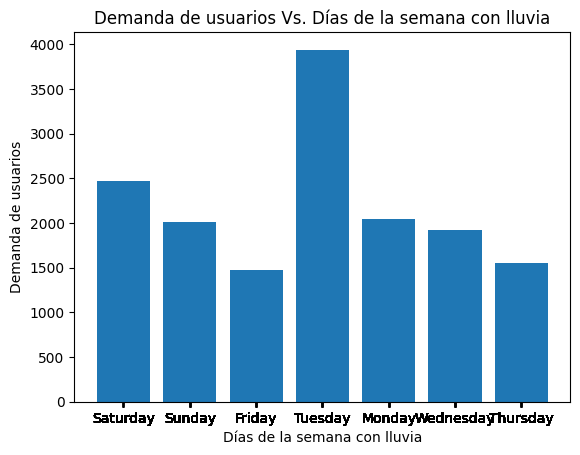

In [32]:
x_values = df_rainy_day['dayOfWeek']
y_values = df_rainy_day['cnt']
plt.figure()    #Figura. Puede incluirse el tamaño con figsize
plt.bar(x_values, y_values)          #El gráfico
plt.title('Demanda de usuarios Vs. Días de la semana con lluvia')      #El título
ax = plt.subplot()                   #Axis
ax.set_xticks(x_values)             #Eje x
ax.set_xticklabels(x_values)        #Etiquetas del eje x
ax.set_xlabel('Días de la semana con lluvia')  #Nombre del eje x
ax.set_ylabel('Demanda de usuarios')  #Nombre del eje y

In [156]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB
None


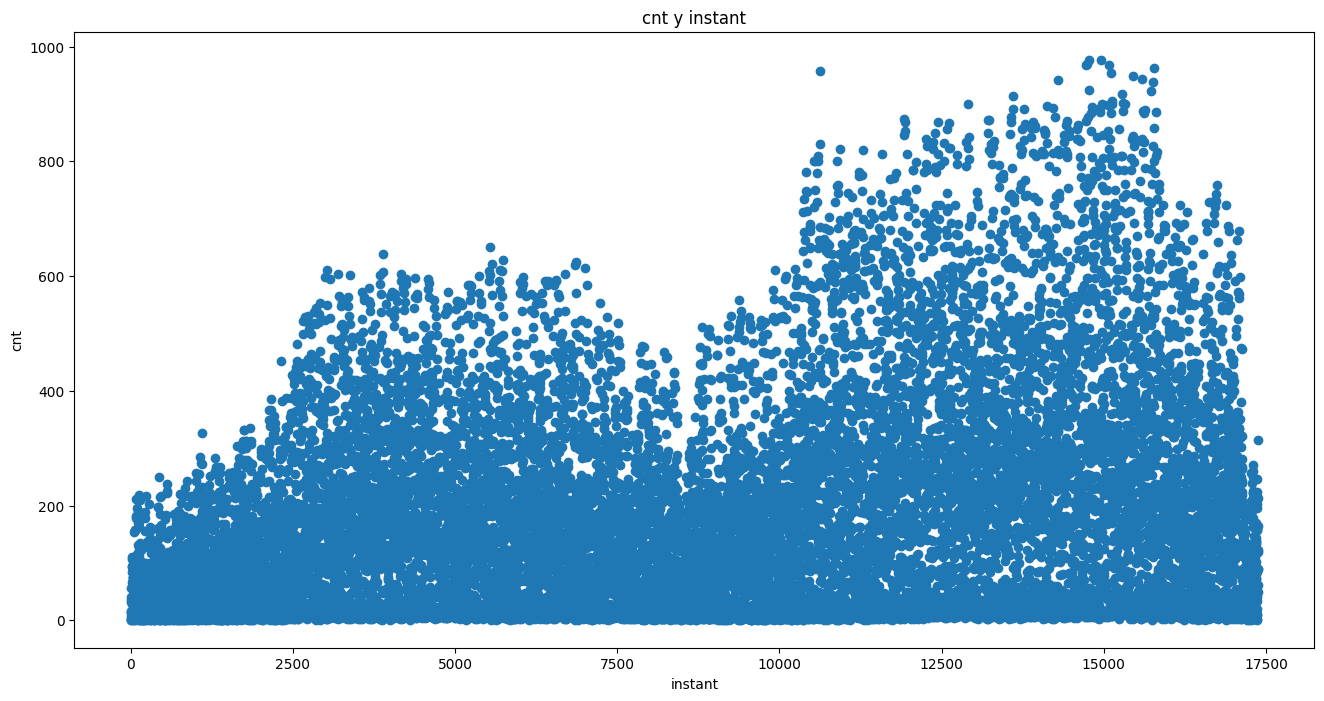

In [157]:
x = 'instant'
y = 'cnt'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

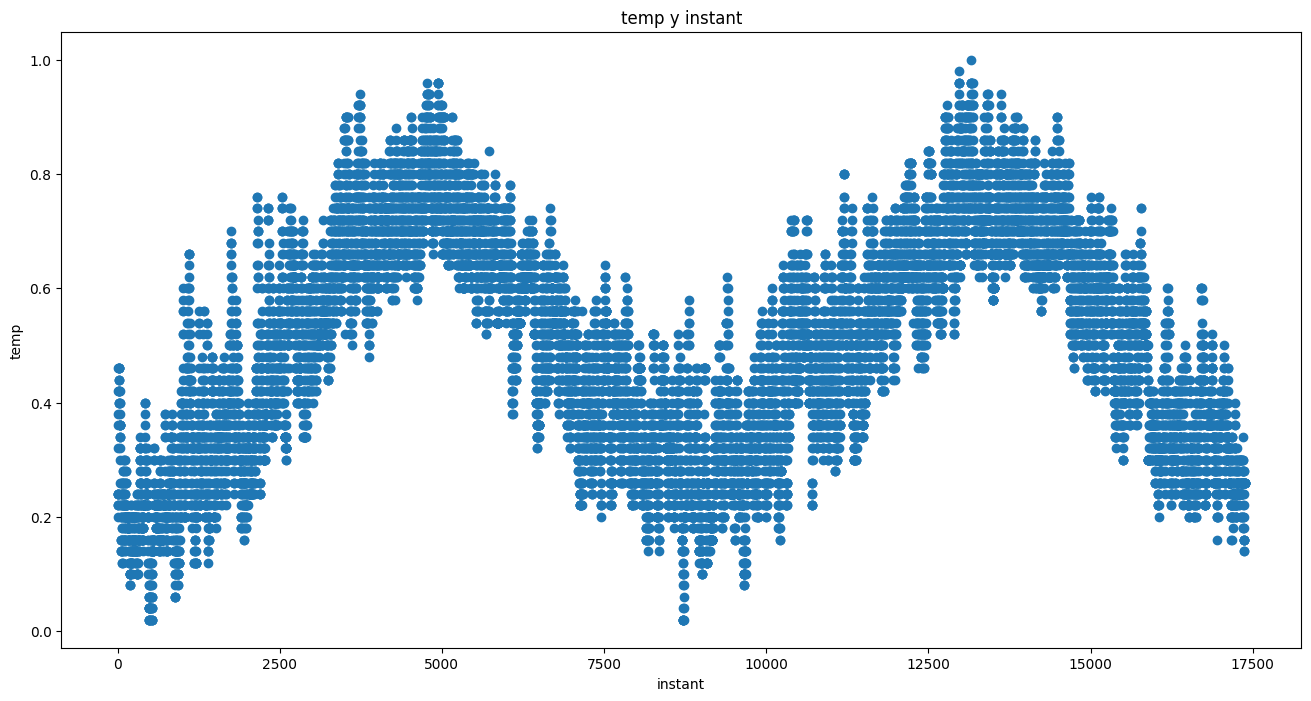

In [158]:
x = 'instant'
y = 'temp'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

<AxesSubplot:>

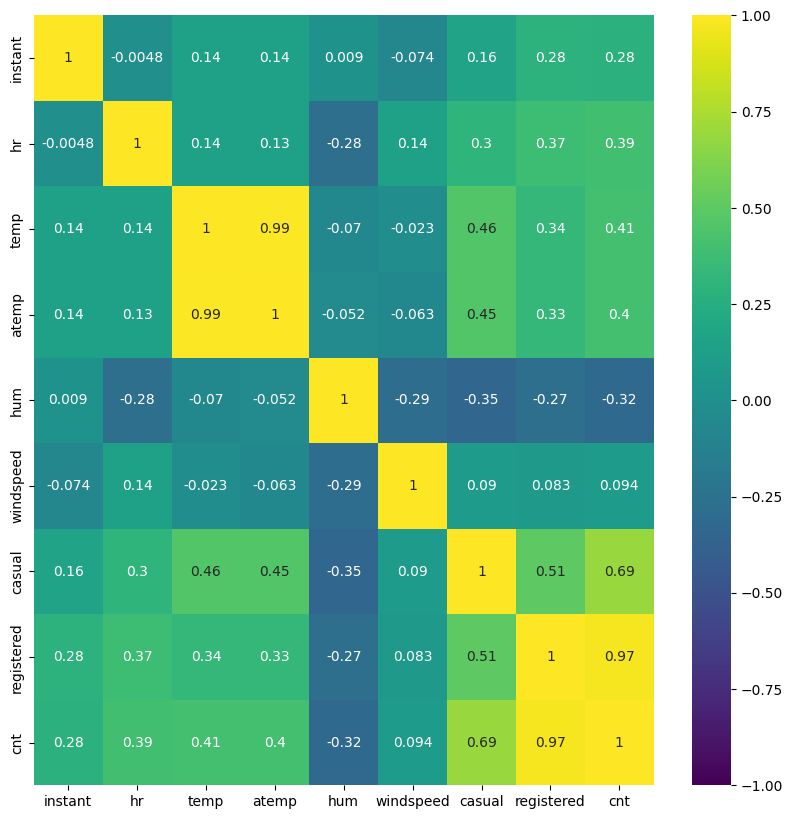

In [159]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap="viridis", vmin = -1, vmax = 1)

# Formato Datos 

Los datos están por hora, lo que dificulta en gran medida el análisis ya que se agrega muchísimo ruido de horas poco útiles. Para este caso de uso, trabajaremos con predicción de la demanda diaria. 

In [16]:
df_byday = df.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day 

In [11]:
df_byday

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


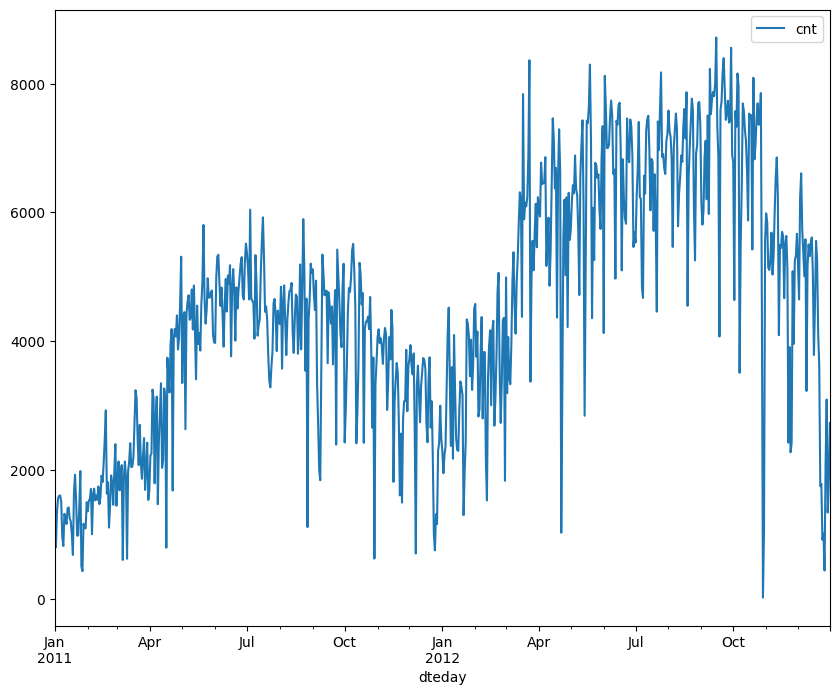

In [162]:
df_byday.plot(x='dteday',y='cnt', figsize=(10,8))
plt.show()

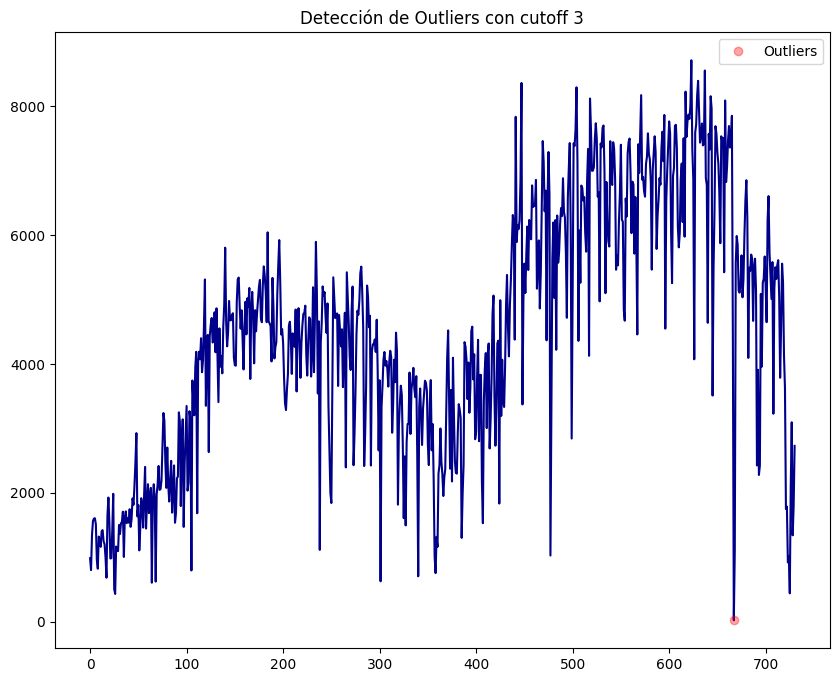

In [163]:
# Outliers
indices = plot_outliers_signal(df_byday.cnt.values, threshold = 3)
plt.show()

In [164]:
df_byday.iloc[indices]

,dteday,cnt
667,2012-10-29,22


Agregamos todas las variables que nos eran útiles. Sin embargo, no todas las podemos tratar de la misma forma

# Feature Engineering ( Creamos variables a raíz de nuestros datos)

In [165]:
# Código de feature engineering.
df_byday.isnull().sum()

dteday    0
cnt       0
dtype: int64

In [17]:
# Código de feature engineering.
df_byday['dteday'] = pd.to_datetime(df_byday['dteday'])  # la cambiamos a formato fecha
#df_byday.dropna(inplace=True)
#df_byday.set_index('dteday', inplace=True)# Para facilidad, utilizamos ds como ínidice.
df_byday

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


In [18]:
df_byday['dayOfWeek'] = df_byday['dteday'].dt.day_name()
df_byday

,dteday,cnt,dayOfWeek
0,2011-01-01,985,Saturday
1,2011-01-02,801,Sunday
2,2011-01-03,1349,Monday
3,2011-01-04,1562,Tuesday
4,2011-01-05,1600,Wednesday
...,...,...,...
726,2012-12-27,2114,Thursday
727,2012-12-28,3095,Friday
728,2012-12-29,1341,Saturday
729,2012-12-30,1796,Sunday


Text(0, 0.5, 'Demanda de usuarios')

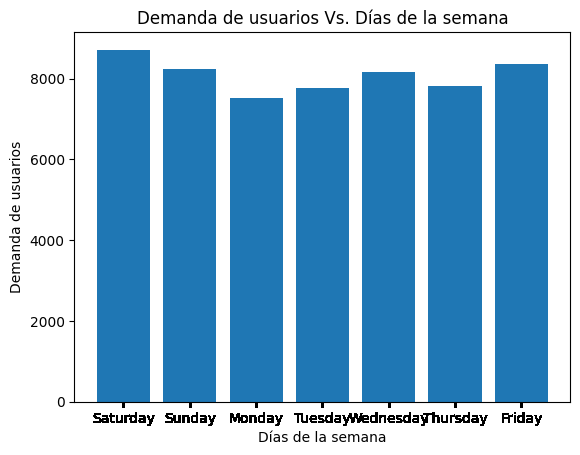

In [20]:
x_values = df_byday['dayOfWeek']
y_values = df_byday['cnt']
plt.figure()    #Figura. Puede incluirse el tamaño con figsize
plt.bar(x_values, y_values)          #El gráfico
plt.title('Demanda de usuarios Vs. Días de la semana')      #El título
ax = plt.subplot()                   #Axis
ax.set_xticks(x_values)             #Eje x
ax.set_xticklabels(x_values)        #Etiquetas del eje x
ax.set_xlabel('Días de la semana')  #Nombre del eje x
ax.set_ylabel('Demanda de usuarios')  #Nombre del eje y

In [167]:
#Attention here, see if trend is linear, how it is extracted, etc !!!
cnt_ts = df_byday.cnt.copy()
to_decompose = cnt_ts.asfreq('D')
decomp_data = seasonal_decompose(
    to_decompose, model='additive',
    extrapolate_trend=True
)

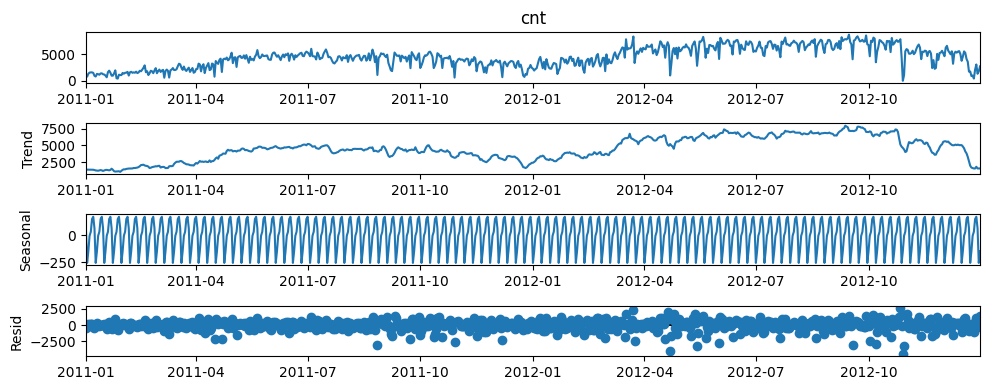

In [168]:
fig = decomp_data.plot()
fig.set_size_inches((10, 4))
# Tight layout para mejorar la viz
fig.tight_layout()
plt.show()  # Graficamos Trend, seasonality

In [169]:
# Agregamos la nueva columna de sesonality 
target_col = 'cnt'
# Añadimos trend y seasonality
df_byday['trend'] = decomp_data.trend.values
df_byday['seasonality'] = decomp_data.seasonal.values

# Seperamos entre test y train por un eje temporal. 

TRAIN_TEST_RATIO = 0.25  # % de datos que iran al test

cut = int(len(df_byday) * (1 - TRAIN_TEST_RATIO))

train = df_byday.iloc[ : cut]
test = df_byday.iloc[cut : ]
# Añadimos una constante ya que son relevantes para calcular 
# el intercept en los modelos lineales
train = sm.tools.add_constant(train)
test =  sm.tools.add_constant(test)


# Separación entre variables dependientes e independiente
X_train = train.loc[:, train.columns != target_col] 
y_train = train[target_col]
X_test = test.loc[:, test.columns != target_col] 
y_test = test[target_col]

# ENTRENAMOS EL MODELO
model = OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     1243.
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          8.38e-204
Time:                        00:26:44   Log-Likelihood:                -4386.8
No. Observations:                 548   AIC:                             8780.
Df Residuals:                     545   BIC:                             8792.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -22.7755     86.398     -0.264      

# Modelo de Machine Learning

R Squared: 0.71


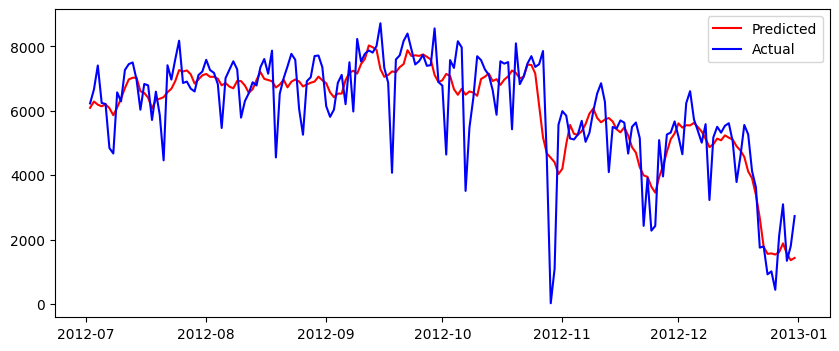

In [170]:
# Resolución Modelo
# Comprobamos que los resultados se mantengan en el set de test

pred = results.predict(X_test)

print(f'R Squared: {round(r2_score(y_test, pred) , 2)}')

f = plt.figure(figsize=(10,4))
plt.plot(pred, c='r', label='Predicted')
plt.plot(y_test, c='b', label='Actual')
plt.legend()
plt.show()

# Evaluación Modelo